Import core numerical and utility functionality

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

Setup

In [2]:
np.random.seed(42)

NAME = 'assignment1'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


## Michaelis-Menten Equation

In [7]:
def michaelis_menten(substrate, km, vmax):
    return vmax * substrate / (km + substrate)

def plot_michaelis_menten(substrate_range, v, km=None, vmax=None, color='tab:blue'):
    fig = plt.figure(figsize=(4, 3), dpi=300, layout='tight')
    plt.plot(substrate_range, v, color=color)
    plt.xlabel('Substrate concentration $[S]$')
    if vmax:
        plt.ylim(0, vmax*1.05)
        plt.yticks([0, vmax/2, vmax], ['0', '$\\frac{V_{max}}{2}$', '$V_{{max}}$'])
    plt.ylabel('Reaction rate $v$')
    plt.title(f'Michaelis-Menten kinetics')
    if km and vmax: 
        plt.legend([f'$K_m={km}, V_{{max}}={vmax}$'])
    return fig

def plot_comparison_michealis_menten(substrate_range, kms, vmaxs, colors, line_vmax=True, line_km=False):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    for (km, vmax, col) in zip(kms, vmaxs, colors):
        v = michaelis_menten(substrate_range, km, vmax)
        ax.plot(substrate_range, v, color=col, label=f'$K_m={km}, V_{{max}}={vmax}$', lw=2.5)
        if line_vmax:
            ax.hlines(vmax, substrate_range[0], substrate_range[-1], linestyles="dashed", color='grey')
        if line_km:
            ax.hlines(0.5 * vmax, substrate_range[0], km, linestyles="dotted", color='grey')
            ax.vlines(km, v[0], 0.5 * vmax, linestyles="dotted", color='grey')

    ax.set_ylim((0, max(vmaxs) * 1.05))
    ax.set_xlabel("Substrate concentration " + r"$[S]$")
    ax.set_ylabel("Reaction rate " + r"$v$")
    ax.legend(loc="lower right")
    ax.set_title("Michaelis-Menten kinetics comparison")
    return fig

Visualize Michaelis-Menten kinetics using the corresponding equation

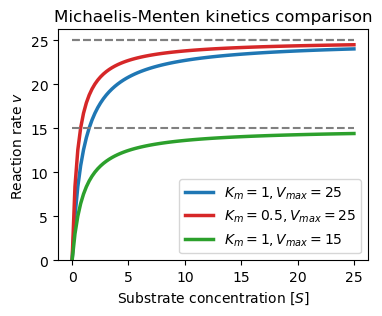

In [169]:
substrate = np.linspace(0, 25, 100)
kms = [1, 0.5, 1]
vmaxs = [25, 25, 15]
colors = ['tab:blue', 'tab:red', 'tab:green']
for km, vmax, color in zip(kms, vmaxs, colors):
    v = michaelis_menten(substrate, km, vmax)
    fig = plot_michaelis_menten(substrate, v, km, vmax, color=color)
    fig.savefig(f'{MEDIA_PATH}/michaelis_menten_km={km}_vmax={vmax}.png', bbox_inches='tight')
    plt.close(fig)
fig_comp = plot_comparison_michealis_menten(substrate, kms, vmaxs, colors)
fig_comp.savefig(f'{MEDIA_PATH}/michaelis_menten_comparison.png', bbox_inches='tight')

Import data and estimate parameters using `scipy.optimize.curve_fit`

In [170]:
# Import data
data = pd.read_csv('data/measuredData.csv', sep=',', names=['[S]', '[V]'])

# Fit data
model = curve_fit(michaelis_menten, data['[S]'], data['[V]'], p0=[1, 1])
km, vmax = model[0]

x = np.linspace(0, max(data['[S]']), 100)
data_substrate = data['[S]']
data_v = data['[V]']
v_fitted = michaelis_menten(x, km, vmax)

Visualize dataset and fitted function

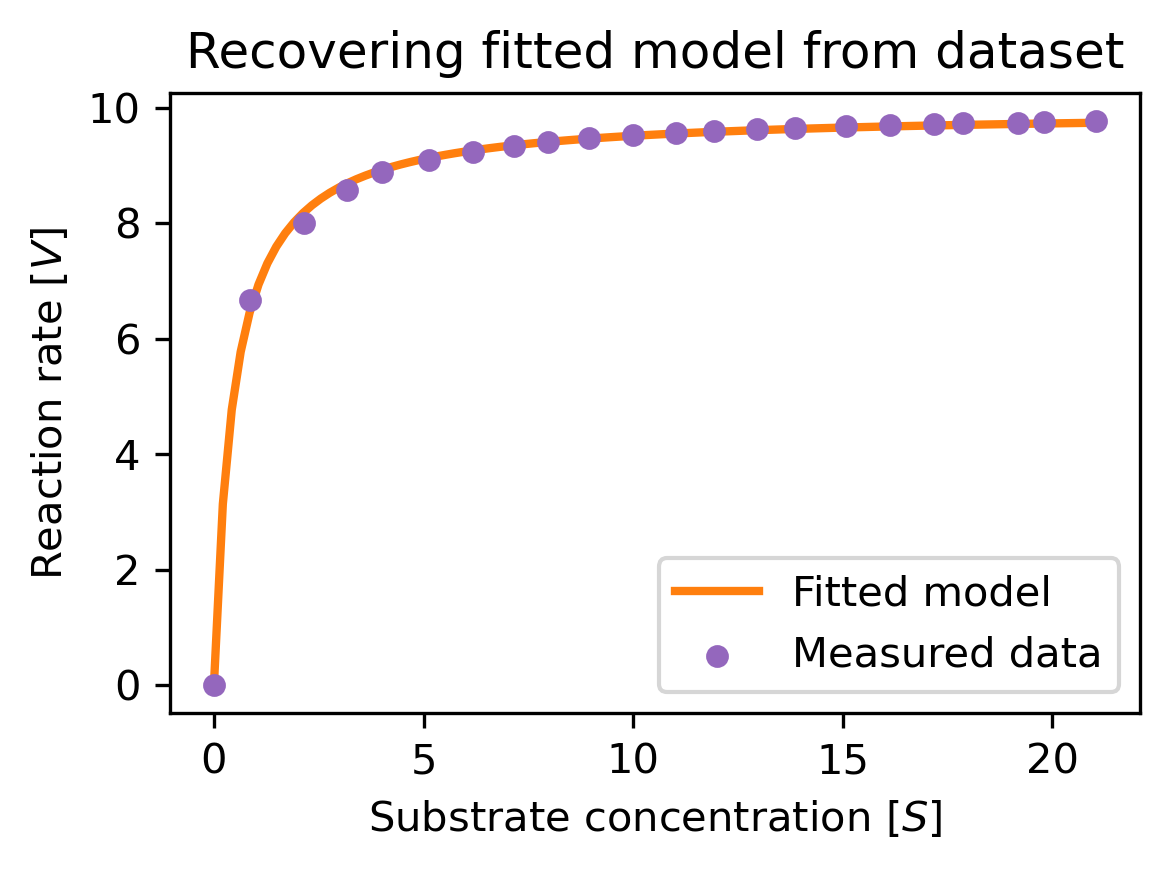

In [171]:
fig = plt.figure(figsize=(4, 3), dpi=300, layout='tight')
plt.plot(x, v_fitted, color='tab:orange', label='Fitted model', linewidth=2)
plt.scatter(data_substrate, data_v, s=20, color='tab:purple', label='Measured data', zorder=2)
plt.xlabel('Substrate concentration $[S]$')
plt.ylabel('Reaction rate $[V]$')
plt.legend()
plt.title('Recovering fitted model from dataset')
fig.savefig(f'{MEDIA_PATH}/fitted_model_from_dataset.png', bbox_inches='tight')

## Lineweaver-Burk

In [172]:
def plot_lineweaver_burk(substrate_range, v, x, v_fitted, km=None, vmax=None, color='tab:blue'):
    fig = plt.figure(figsize=(4, 3), dpi=300, layout='tight')
    plt.scatter(1/substrate_range[substrate_range != 0], 1/v[v != 0], color=color, s=5, label='Data')
    plt.plot(1/x[x != 0], 1/v_fitted[v_fitted != 0], color='tab:orange', label=f'Model $K_m={km:.2f}, V_{{max}}={vmax:.2f}$', linewidth=1, zorder=-2, alpha=0.7)
    plt.xlabel('Substrate concentration inverse $\\frac{1}{[S]}$')
    plt.ylabel('Reaction rate inverse $\\frac{1}{v}$')
    plt.title(f'Lineweaver-Burk visualization')
    plt.legend()
    return fig

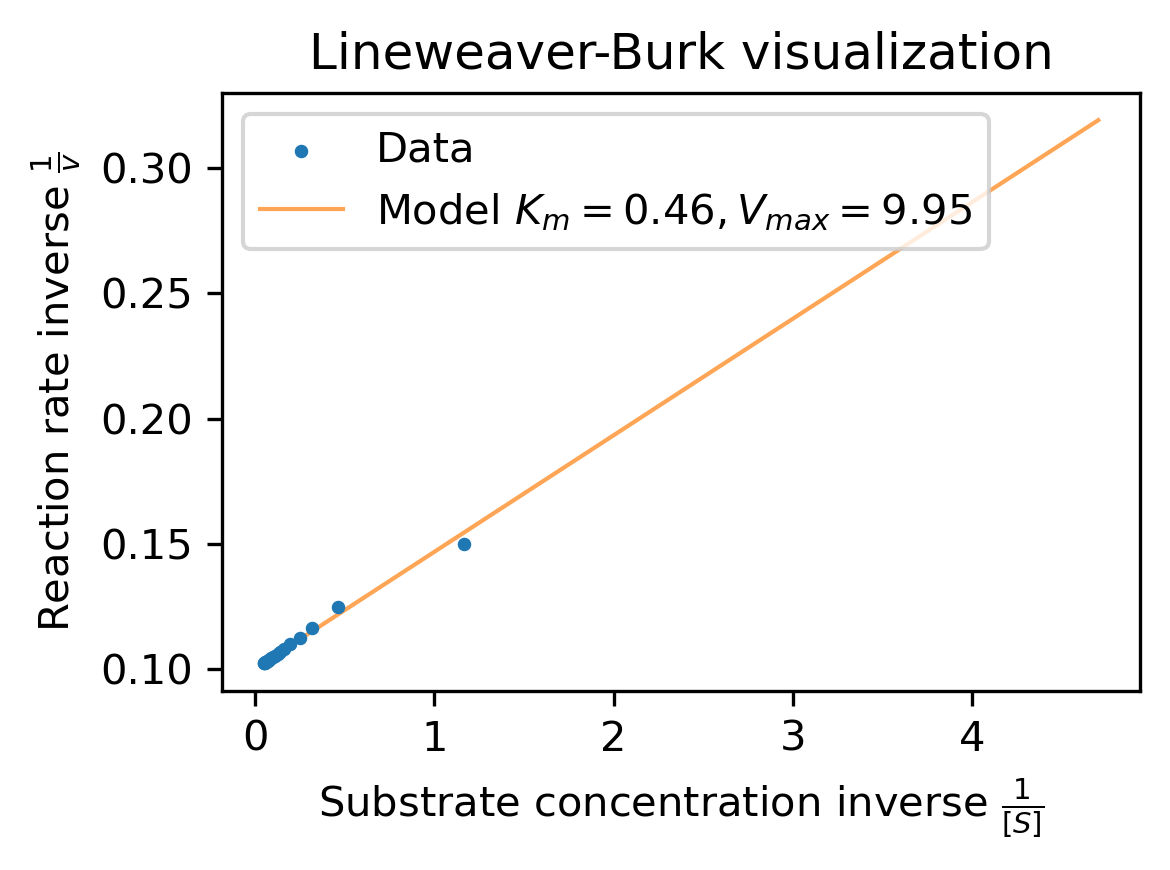

In [173]:
model = curve_fit(michaelis_menten, data_substrate[1:], data_v[1:], p0=[1, 1])
km, vmax = model[0]

x = np.linspace(0, max(data_substrate[1:]), 100)
v_fitted = michaelis_menten(x, km, vmax)

fig = plot_lineweaver_burk(data_substrate[1:], data_v[1:], x, v_fitted, km, vmax)
fig.savefig(f'{MEDIA_PATH}/lineweaver_burk.png', bbox_inches='tight')

In [174]:
def linear_equation(sinv, a, b):
    return a + b * sinv

popt, _ = curve_fit(linear_equation, 1/data_substrate[1:], 1/data_v[1:])
a, b = popt

vmaxopt = 1 / a
kmopt = b / a

print(f"Estimated Vmax = {np.round(vmaxopt, 2)}")
print(f"Estimated Km = {np.round(kmopt, 2)}")

Estimated Vmax = 9.92
Estimated Km = 0.44


## Inhibitors

In [5]:
def michaelis_menten_inhibition(substrate, inhibitor, km, vmax, ki, inhib_type):
    if inhib_type == 'competitive':
        return vmax * substrate / ((1 + inhibitor/ki) * km + substrate)
    elif inhib_type == 'uncompetitive':
        return vmax * substrate / (km + (1 + inhibitor/ki) * substrate)
    elif inhib_type == 'noncompetitive':
        return vmax * substrate / ((1 + inhibitor/ki) * (km + substrate))

In [3]:
km = 1
vmax = 12
substrate = np.linspace(0, 10, 100)
colors = ['tab:blue', 'tab:red', 'tab:green']
kis = [2, 5, 2]
inhibitors = [2, 2, 5]
inhib_types = ['competitive', 'uncompetitive', 'noncompetitive']

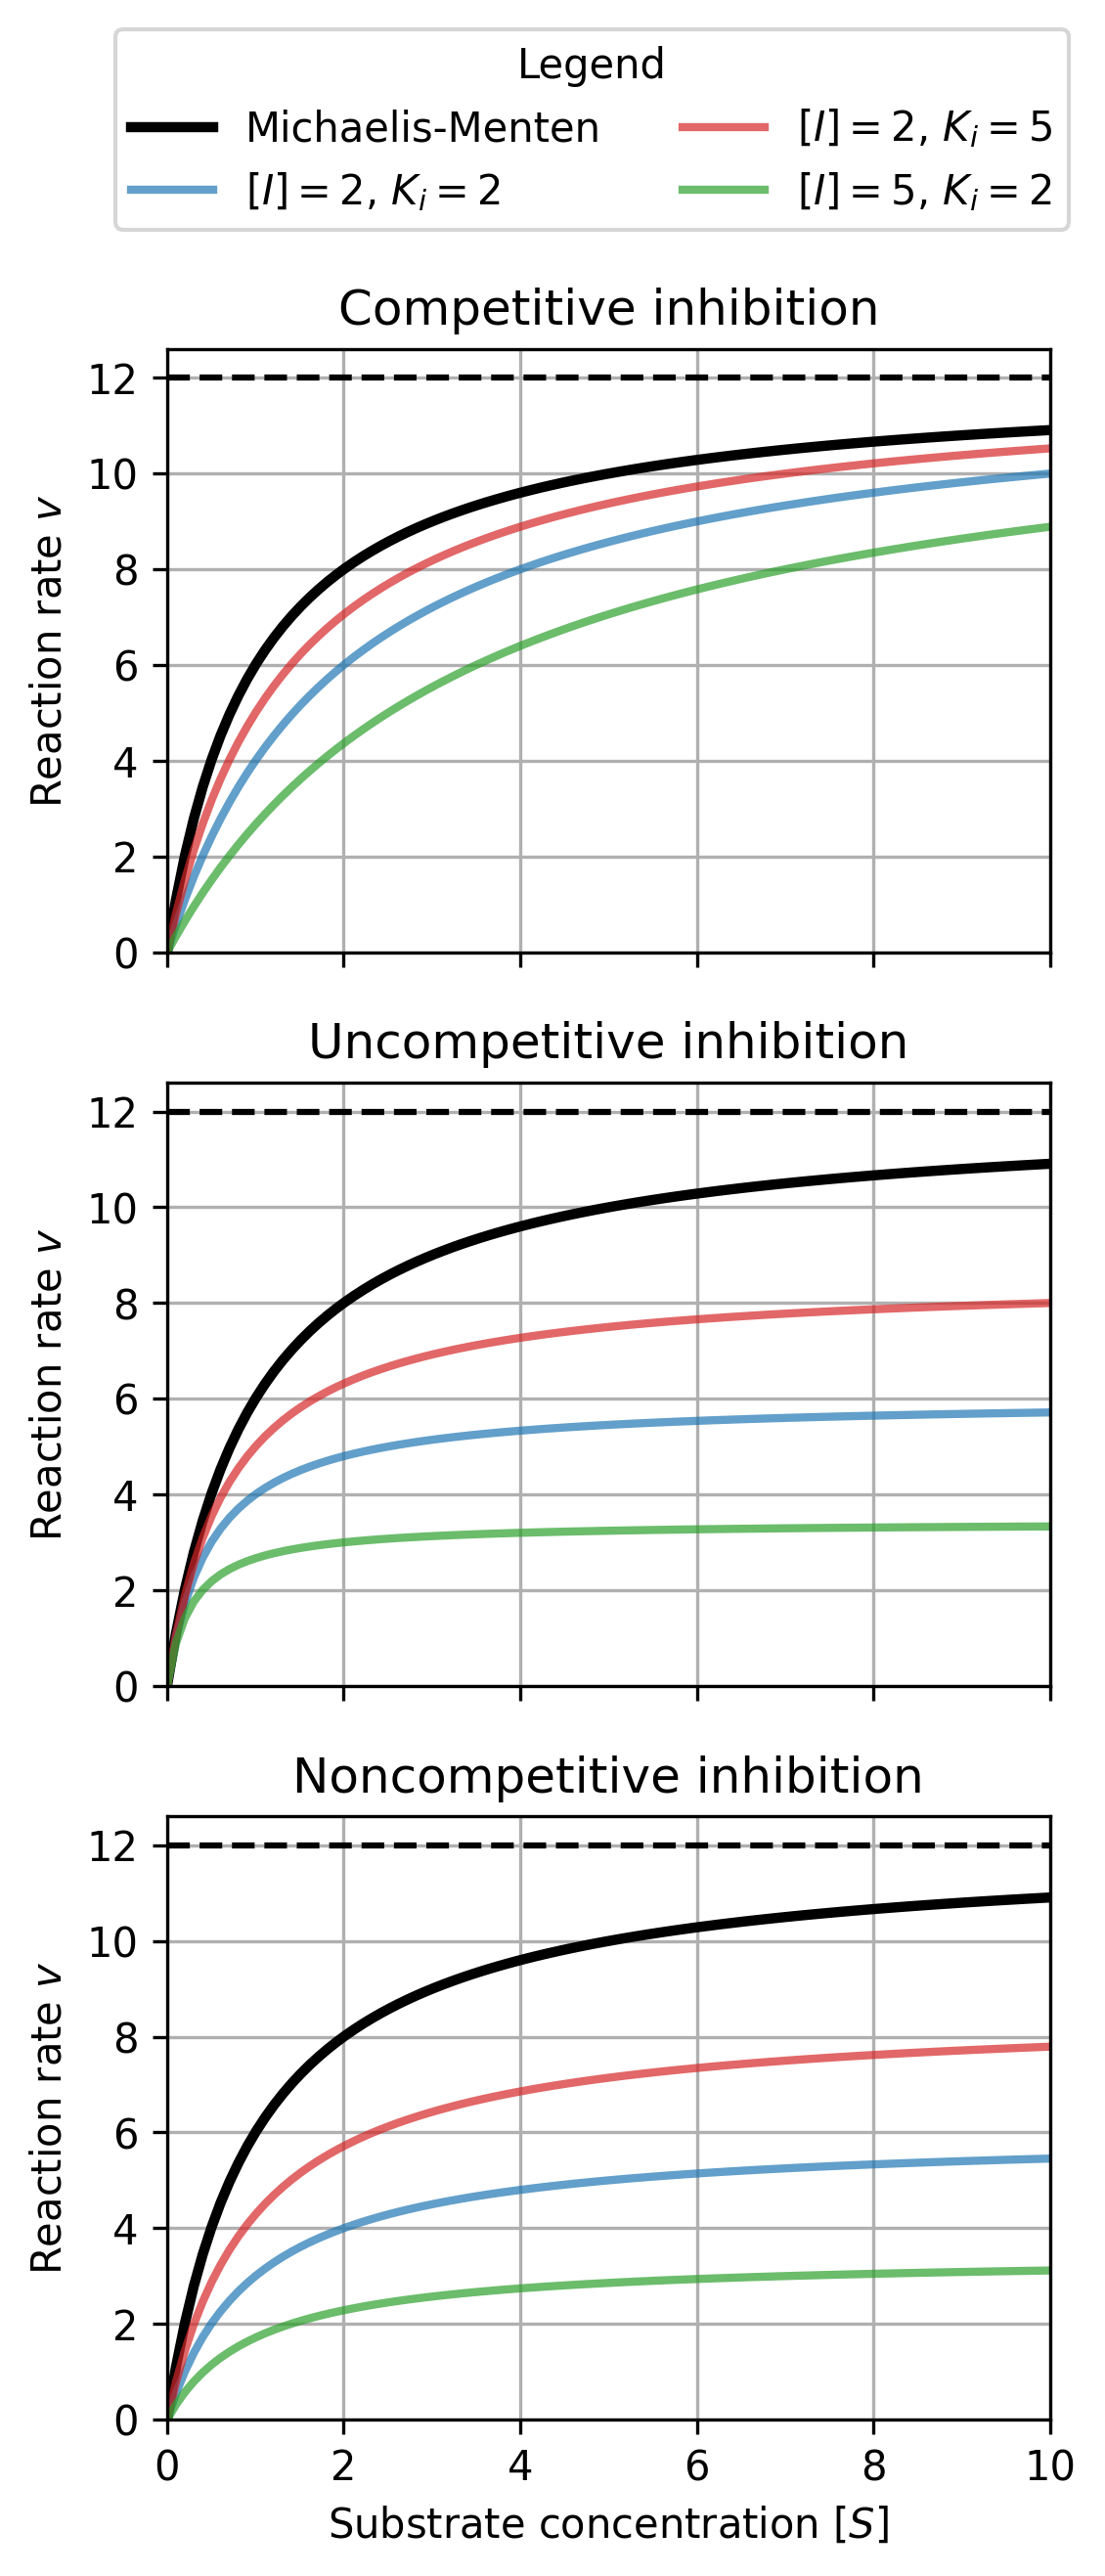

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(4, 8), sharex=True, layout='tight', dpi=300)
lines = []
labels = []
for i, (ax, inhib_type) in enumerate(zip(axs, inhib_types)):
    vs = michaelis_menten(substrate, km, vmax)
    ax.hlines(vmax, substrate[0], substrate[-1], linestyles="dashed", color='black')
    line, = ax.plot(substrate, vs, label="Michaelis-Menten", color="black", lw=2.5)
    if i == 0:
        lines.append(line)
        labels.append("Michaelis-Menten")
    ax.set_ylim((0, vmax * 1.05))
    ax.set_xlim((0, substrate[-1]))
    ax.set_ylabel("Reaction rate $v$")

    for inhib, ki, color in zip(inhibitors, kis, colors):
        vs = michaelis_menten_inhibition(substrate, inhib, km, vmax, ki, inhib_type)
        line, = ax.plot(substrate, vs, label=f"$[I]={inhib}$, $K_i={ki}$", color=color, lw=2, alpha=0.7)
        if i == 0:
            lines.append(line)
            labels.append(f"$[I]={inhib}$, $K_i={ki}$")
    ax.grid(True)
    ax.set_title(f"{inhib_type.capitalize()} inhibition")
axs[-1].set_xlabel("Substrate concentration $[S]$")

# Create a legend for the whole figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.55, 1.1), ncol=2, title='Legend')
fig.savefig(f'{MEDIA_PATH}/michaelis_menten_inhibition.png', bbox_inches='tight')
plt.show()

In [178]:
ss2, vv2 = np.genfromtxt("data/DataI2.csv", delimiter=",").T
ss5, vv5 = np.genfromtxt("data/DataI5.csv", delimiter=",").T
ss8, vv8 = np.genfromtxt("data/DataI8.csv", delimiter=",").T

xx = np.linspace(-0.05, 1.1, 1000)

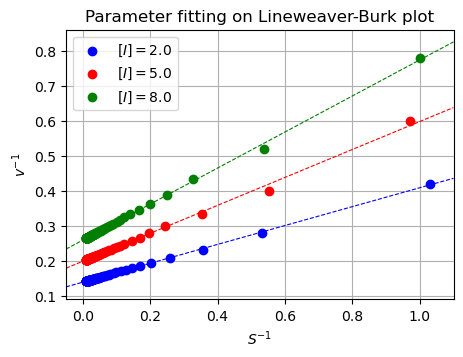

In [179]:
ssinv2, vvinv2 = 1 / ss2[1:], 1 / vv2[1:]
ssinv5, vvinv5 = 1 / ss5[1:], 1 / vv5[1:]
ssinv8, vvinv8 = 1 / ss8[1:], 1 / vv8[1:]

fig, ax = plt.subplots(1,1,figsize=(5,3.5))

ax.set_xlabel(r"$S^{-1}$")
ax.set_ylabel(r"$v^{-1}$")

ax.set_xlim((-0.05, 1.1))

ax.grid()

ax.scatter(ssinv2, vvinv2, color="blue", zorder=10, label=r"$[I]=2.0$")
popt2, _ = curve_fit(linear_equation, ssinv2, vvinv2)
a, b = popt2
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="blue", lw=0.8)

ax.scatter(ssinv5, vvinv5, color="red", zorder=10, label=r"$[I]=5.0$")
popt5, _ = curve_fit(linear_equation, ssinv5, vvinv5)
a, b = popt5
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="red", lw=0.8)

ax.scatter(ssinv8, vvinv8, color="green", zorder=10, label=r"$[I]=8.0$")
popt8, _ = curve_fit(linear_equation, ssinv8, vvinv8)
a, b = popt8
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="green", lw=0.8)

ax.legend()
ax.set_title("Parameter fitting on Lineweaver-Burk plot")
fig.savefig(f'{MEDIA_PATH}/lineweaver_burk_inhibition.png', bbox_inches='tight')
plt.show()